# Import Dependencies

In [1]:
import numpy as np
import os
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Activation, ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape, BatchNormalization, Bidirectional, Layer, Add, Lambda, AveragePooling3D
from keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
import sklearn
import seaborn as sns
import tensorflow as tf
from keras import regularizers
from prettytable import PrettyTable
from tqdm import tqdm

In [5]:
physical_devices = tf.config.list_physical_devices('CPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [27]:
for root, dirs, files in os.walk('D:/Programming/Code/Python/CustomLipReading/data'):
    print(root)

In [3]:
# Set the directory path where the text files are located
dir_path = "D:/Programming/Code/Python/CustomLipReading/data"

# Set the dimensions of each frame
height, width, channels = 80, 112, 3

# Initialize arrays to store the video frames and their corresponding labels
videos = []
labels = []
counter = 0
i = 0
# Loop through each text file and extract the video frames
for root, dirs, files in tqdm(os.walk(dir_path), total=604):
    # print(root, end='\r')
    for file in files:
        # print(file)
        if file == "data.txt":

            # Extract the label from the directory name
            label = root.split("/")[-1]
            label = label.split("_")[0]
            #if label not in wanted_words:
            #    continue
            counter += 1
            # print(counter, end=" ")
            

            with open(os.path.join(root, file), 'r') as f:
                data_str = f.read()

            # Evaluate the contents of the text file as a Python expression
            data_list = eval(data_str)
            
            # Convert the list to a numpy array
            data_array = np.array(data_list)
            #print(data_array.shape)

            # Reshape the data into a 4D array of shape (num_frames, height, width, channels)
            num_frames = len(data_list)
            frames = data_array.reshape((num_frames, height, width, channels))
            # Append the frames and label to the videos and labels arrays
            videos.append(frames)
            labels.append(label)
# print(labels)

# Convert the videos and labels arrays to NumPy arrays
videos = np.array(videos)
labels = np.array(labels)

# Save the videos and labels as separate .npy files
np.save("vid/videosCorrect.npy", videos)
np.save("vid/labelsCorrect.npy", labels)

100%|██████████| 604/604 [16:39<00:00,  1.65s/it]


In [2]:
video_path = 'vid/videosCorrect.npy'
label_path = 'vid/labelsCorrect.npy'

videos = np.load(video_path)
labels = np.load(label_path)

In [3]:
# Print the shape of the videos and labels arrays
print("Videos shape:", videos.shape)
print("Labels shape:", labels.shape)

Videos shape: (2080, 22, 80, 112, 3)
Labels shape: (2080,)


In [4]:
encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)
labels = encoded_labels

# Label preprocessing

In [5]:
fprop = fm.FontProperties(fname='Language/AnnapurnaSIL-Regular.ttf')

In [6]:
label_dict = {0: 'अच्छा', 1: 'एक', 2: 'और', 3: 'कहाँ', 4: 'चार', 5: 'जी', 6: 'ठीक', 7: 'तीन', 8: 'दस', 9: 'देखो', 10: 'नमस्ते', 11: 'पाँच', 12: 'पानी', 13: 'रोटी', 14: 'है'}

In [7]:
# Get the unique classes
classes = np.unique(labels)

# Count the number of occurrences of each class
counts = np.bincount(labels, minlength=len(classes))

# Find the maximum length of the class names for alignment
max_len = max([len(label_dict[i]) for i in range(len(label_dict))])

# Print the distribution of classes
for i, count in enumerate(counts):
    class_name = label_dict[i].ljust(max_len)
    print("{}  {} counts".format(class_name, count))

अच्छा   156 counts
एक      168 counts
और      120 counts
कहाँ    150 counts
चार     128 counts
जी      120 counts
ठीक     168 counts
तीन     150 counts
दस      120 counts
देखो    128 counts
नमस्ते  120 counts
पाँच    150 counts
पानी    132 counts
रोटी    150 counts
है      120 counts


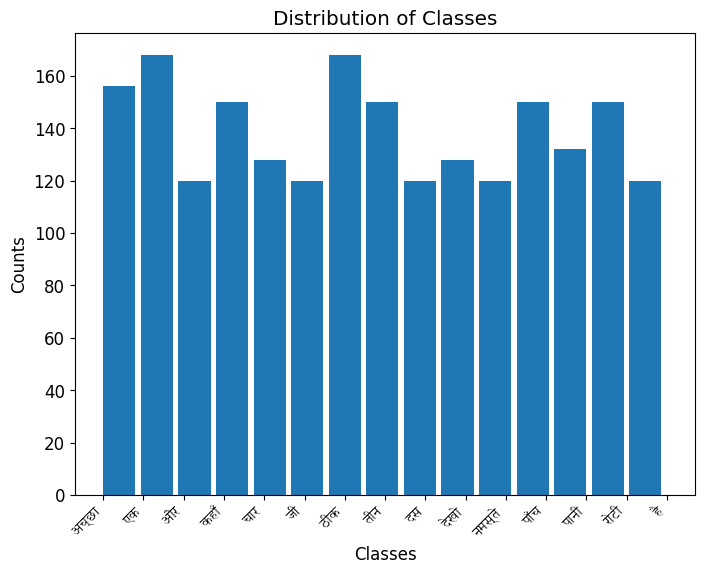

In [8]:
# Get the unique classes
classes = np.unique(labels)

# Count the number of occurrences of each class
counts = np.bincount(labels, minlength=len(classes))

# Set the figure size and font size
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 12})

# Plot the histogram
plt.hist(labels, bins=len(classes), width=0.8)
plt.xticks(range(len(classes)), [label_dict[i] for i in range(len(classes))], rotation=45, ha='right', fontproperties=fprop)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Distribution of Classes')

# Display the plot
plt.show()

# Creating the test-train split

In [9]:
# Split the data into training and validation sets

X_train, X_test, y_train, y_test = train_test_split(videos, labels, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

del videos

Training set shape: (1664, 22, 80, 112, 3) (1664,)
Test set shape: (416, 22, 80, 112, 3) (416,)


# Model Creation

In [18]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [10]:
class ResnetBlock(Layer):
  def __init__(self, filters, strides=1, **kwargs):
    super(ResnetBlock, self).__init__(**kwargs)
    self.filters = filters
    self.strides = strides
    self.conv1 = Conv3D(filters, kernel_size=(3, 3, 3), padding='same', activation='relu')
    self.bn1 = BatchNormalization()
    self.conv2 = Conv3D(filters, kernel_size=(3, 3, 3), padding='same', activation='relu')
    self.bn2 = BatchNormalization()
    self.conv3 = Conv3D(filters, kernel_size=(1, 1, 1), padding='same')
    self.shortcut = Lambda(lambda x: x)  # Identity mapping for shortcut

  # def build(self, input_shape):
  #   self.shortcut.shape = input_shape

  def call(self, inputs):
    shortcut = self.shortcut(inputs)

    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    shortcut = self.conv3(shortcut)

    # Apply downsampling if necessary
    if self.strides != 1:
      shortcut = AveragePooling3D(pool_size=(1, 1, 1), strides=self.strides)(shortcut)

    # Add shortcut and activation
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

  def compute_output_shape(self, input_shape):
    # Output shape remains same except for depth (filters)
    return (input_shape[0], input_shape[1], input_shape[2], self.filters)

In [11]:
# Define video input shape
input_shape = (22, 80, 112, 3)

# Model definition
model = Sequential()

# Convolutional layers for feature extraction
model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# ResNet blocks (adjust filters and repetitions as needed)
for _ in range(3):
    model.add(ResnetBlock(64))

# for _ in range(3):
#     model.add(BasicBlock(128))


# Spatial Attention (optional)

model.add(Reshape((40, -1)))

# Temporal Attention
model.add(Bidirectional(LSTM(64, return_sequences=True)))

# Flatten the output (optional, depending on LSTM implementation)
model.add(Flatten())

# Dense layers for classification
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))  # Regularization
model.add(Dense(128, activation='relu'))

# Output layer
model.add(Dense(15, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert the target labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 22, 80, 112, 32)   2624      
                                                                 
 batch_normalization (BatchN  (None, 22, 80, 112, 32)  128       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 11, 40, 56, 32)   0         
 )                                                               
                                                                 
 basic_block (BasicBlock)    (None, 11, 40, 56, 64)    168640    
                                                                 
 basic_block_1 (BasicBlock)  (None, 11, 40, 56, 64)    225984    
                                                                 
 basic_block_2 (BasicBlock)  (None, 11, 40, 56, 64)    2

# Training

In [12]:
# Train the model and record the history of training
history = model.fit(X_train, y_train_onehot, epochs=20, batch_size=16, validation_split=0.2, steps_per_epoch=26)

Epoch 1/20
26/26 [==============================] - 129s 2s/step - loss: 2.9345 - accuracy: 0.0889 - val_loss: 2.8077 - val_accuracy: 0.0661
Epoch 2/20
26/26 [==============================] - 53s 2s/step - loss: 2.7178 - accuracy: 0.1034 - val_loss: 2.6741 - val_accuracy: 0.0931
Epoch 3/20
26/26 [==============================] - 49s 2s/step - loss: 2.4846 - accuracy: 0.1707 - val_loss: 2.5132 - val_accuracy: 0.2432
Epoch 4/20
26/26 [==============================] - 33s 1s/step - loss: 2.0470 - accuracy: 0.3027 - val_loss: 1.9792 - val_accuracy: 0.3033
Epoch 5/20
26/26 [==============================] - 32s 1s/step - loss: 1.5777 - accuracy: 0.4327 - val_loss: 2.7932 - val_accuracy: 0.2162
Epoch 6/20
26/26 [==============================] - 32s 1s/step - loss: 1.1666 - accuracy: 0.6226 - val_loss: 1.5986 - val_accuracy: 0.4835
Epoch 7/20
26/26 [==============================] - 31s 1s/step - loss: 0.7586 - accuracy: 0.7395 - val_loss: 1.2849 - val_accuracy: 0.5856
Epoch 8/20
26/26 [=

# Performance Evaluation

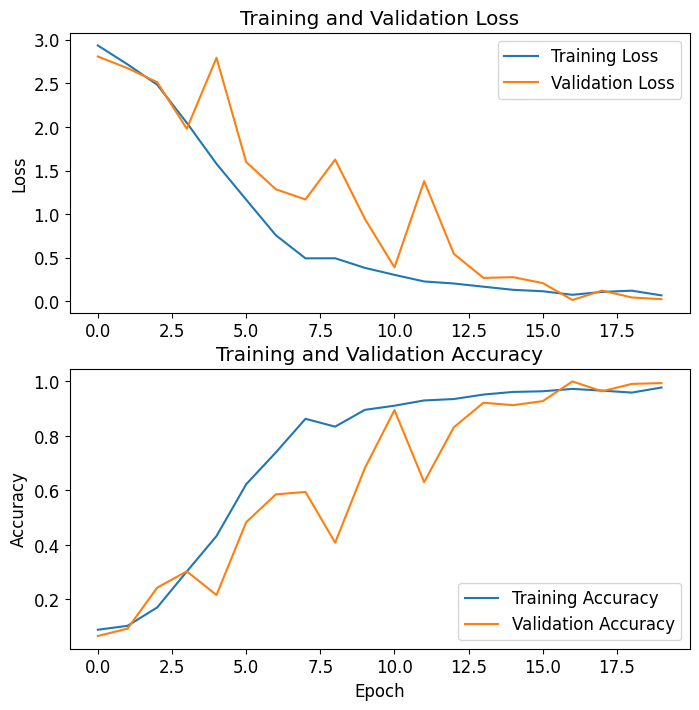

In [13]:
# Plot the training and validation loss and accuracy
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].legend(loc='upper right')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss')

axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].legend(loc='lower right')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy')

plt.xlabel('Epoch')
plt.show()

# Saving the Model

In [17]:
model.save_weights('model/model_weights_RESNET1.h5')

# Loading the Model

In [ ]:
model.load_weights('model/model_weights_RESNET.h5', by_name=True)

# Validation

In [14]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

13/13 [==============================] - 25s 718ms/step


In [15]:
report = classification_report(y_test, y_pred, output_dict=True)

table = PrettyTable()
table.field_names = ["Class", "Precision", "Recall", "F1-Score", "Support"]
for label, metrics in report.items():
    if label.isdigit():
        precision = round(metrics['precision'], 2)
        recall = round(metrics['recall'], 2)
        f1_score = round(metrics['f1-score'], 2)
        support = metrics['support']
        table.add_row([label_dict[int(label)], precision, recall, f1_score, support])

print(table)

+-------+-----------+--------+----------+---------+
| Class | Precision | Recall | F1-Score | Support |
+-------+-----------+--------+----------+---------+
|  अच्छा  |    1.0    |  1.0   |   1.0    |   30.0  |
|   एक  |    1.0    |  1.0   |   1.0    |   38.0  |
|   और  |    1.0    |  0.96  |   0.98   |   28.0  |
|   कहाँ  |    1.0    |  1.0   |   1.0    |   36.0  |
|   चार  |    0.88   |  1.0   |   0.94   |   23.0  |
|   जी   |    1.0    |  1.0   |   1.0    |   22.0  |
|   ठीक  |    1.0    |  1.0   |   1.0    |   31.0  |
|   तीन  |    1.0    |  1.0   |   1.0    |   26.0  |
|   दस  |    1.0    |  1.0   |   1.0    |   17.0  |
|   देखो  |    0.97   |  1.0   |   0.98   |   31.0  |
|  नमस्ते |    1.0    |  1.0   |   1.0    |   31.0  |
|   पाँच  |    1.0    |  0.9   |   0.95   |   31.0  |
|   पानी  |    1.0    |  0.86  |   0.92   |   21.0  |
|   रोटी  |    0.88   |  1.0   |   0.94   |   23.0  |
|   है   |    1.0    |  1.0   |   1.0    |   28.0  |
+-------+-----------+--------+----------+----

In [16]:
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))

Balanced accuracy: 0.9816436251920123


# ROC

13/13 [==============================] - 8s 678ms/step


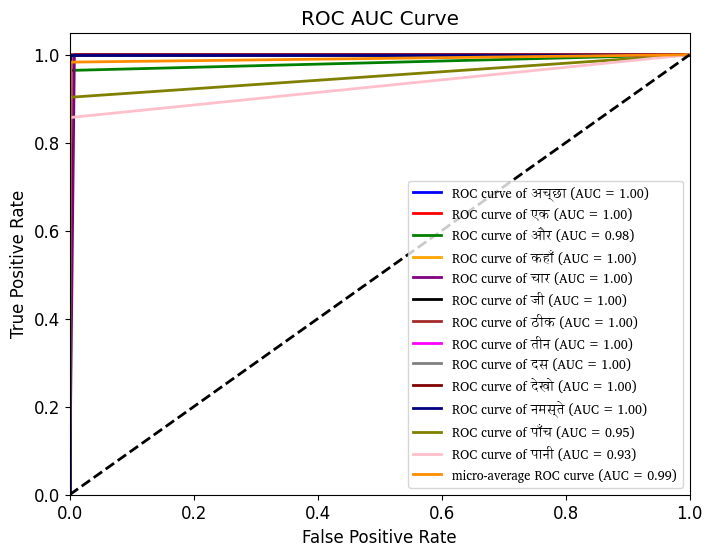

In [18]:
# Convert y_true and y_pred to one-hot encoding
n_classes = len(np.unique(y_test))
y_true_bin = label_binarize(y_test, classes=np.arange(n_classes))
y_pred_bin = model.predict(X_test)
y_pred_bin = label_binarize(np.argmax(y_pred_bin, axis=1), classes=np.arange(n_classes))

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curves
plt.figure(figsize=(8,6))
lw = 2
colors = ['blue', 'red', 'green', 'orange', 'purple', 'black', 'brown', 'magenta', 'gray', 'maroon', 'navy', 'olive', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
             label='ROC curve of {0} (AUC = {1:0.2f})'
             ''.format(label_dict[i], roc_auc[i]))
plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=lw,
         label='micro-average ROC curve (AUC = {0:0.2f})'
         ''.format(roc_auc_micro))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right", prop = fprop)
plt.show()

# Confusion Matrix

c:\Users\megar\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.draw()
c:\Users\megar\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
c:\Users\megar\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2330 (\N{DEVANAGARI LETTER CA}) missing from current font.
  fig.canvas.draw()
c:\Users\megar\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from current font.
  fig.canvas.draw()
c:\Users\megar\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2331 (\N{DEVANAGARI LETTER CHA}) missing from current font.
  fig.canvas.draw()
c:\Users\megar\AppData\Local\Programs\Python\Pyth

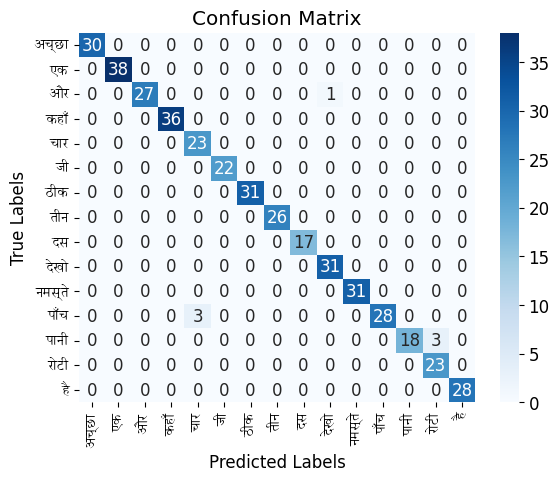

In [19]:
conf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

# Define the list of label strings in the order of their integer values
label_strings = [label_dict[i] for i in range(len(label_dict))]

# Generate the heatmap confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=label_strings, yticklabels=label_strings)
plt.xticks(fontproperties=fprop)
plt.yticks(fontproperties=fprop)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()